# ICESAT1_fixing_blocky_residual_problems

The residual stuff, zp etc, is so blocky that it doesnt really calculate good change. Need to either smooth grad or final zp.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 24 11:00:37 2020

@author: whitefar
"""

# You can calculate the residuals from the track*_all_dzdt.mat files in /Users/home/horganhu/ICESAT_LINK/TAMATA_ICESAT/GLA12_633_DZDT/

# track0099_all_dzdt.mat
# dzdt.track0099.bin2963.grad,
# dzdt.track0099.bin2963.dzdt,
# dzdt.track0099.bin2963.x,
# dzdt.track0099.bin2963.y,
# dzdt.track0099.bin2963.z,
# dzdt.track0099.bin2963.retide,
# dzdt.track0099.bin2963.sdatedays,
# dzdt.track0099.bin2963.elev_wgs84_tpxtide,
# dzdt.track0099.bin2963.lat,
# dzdt.track0099.bin2963.lon,
# dzdt.track0099.bin2963.ret

# zp = [x-mean(x); y-mean(y)]'*grad + (t-t0)'*(bindzdt) + mean(z); % Note here we use z here (not elev)

# zp=zp';

# res = z - zp;     % transient changes (footprint elevation changes corrected for
#                 % slope and secular change. Note here we use z here (not elev)

# dz=res + ((t - t0).*bindzdt);   % Elevation change corrected for each segment. This is
#                 % corrected for gradient. Note, this is per day.

'\nCreated on Wed Jun 24 11:00:37 2020\n\n@author: whitefar\n'

In [2]:
import h5py
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from shapely.ops import nearest_points
import numpy as np
from tqdm import tqdm
from scipy import interpolate
import datetime as dt
from scipy.signal import savgol_filter

In [3]:
def icesat1_alldzdt_todataframe(track):
    """
    this function will import the .mat and arrange into a dataframe
    track = eg track
    
    da is a Dataframe restricted to the channel Area
    """
    
    
    
    path = f'/Users/home/horganhu/ICESAT_LINK/TAMATA_ICESAT/GLA12_633_DZDT/{track}_all_dzdt.mat'
    da = pd.DataFrame({'x':[],
                       'pass_num':[],
                      })
    psys = []
    h = []
    UTCtime = []
    dh = []
    with h5py.File(path, 'r') as f:
        
        bins = list(f['dzdt'][track].keys())
        
        #make dataframe
        for b in tqdm(bins):
            
            x_arr = f['dzdt'][track][b]['x'][0]
            x_len = x_arr.shape[0]
            x_list = list(x_arr)
        
            grad = (list(f['dzdt'][track][b]['grad'][0])[0],list(f['dzdt'][track][b]['grad'][1])[0])
            df_temp =  pd.DataFrame({'x': x_list,
                                    'y': list(f['dzdt'][track][b]['y'][0]),
                                    'bin_number': [b]*x_len,
                                    'dzdt': list(f['dzdt'][track][b]['dzdt'][0])*x_len,
                                    'elev_wgs84_tpxtide': list(f['dzdt'][track][b]['elev_wgs84_tpxtide'][0]),
                                    'grad':[grad]*x_len,
                                    'ret': list(f['dzdt'][track][b]['ret'][0])*x_len,
                                    'retide': list(f['dzdt'][track][b]['retide'][0]),
                                    'sdatedays': list(f['dzdt'][track][b]['sdatedays'][0]),
                                    'z': list(f['dzdt'][track][b]['z'][0])
                                   })
 
            da_temp = df_temp.query("x > -382064.5722209641 & x < -374781.1654740692 & y > -734075.0820404041 & y < -722764.4514729496")
            
            da = da.append(da_temp, ignore_index=True )
        
            del df_temp, da_temp
            
    da.reset_index(drop=True,inplace=True)
    
    da.to_pickle(f'/Users/home/whitefar/DATA/REMOTE_SENSING/ICESAT1/dataframe_{track}_alldzdt.pkl')
    
# #all the paths of relevant .mat icesat1 files
# paths = glob.glob('/Users/home/horganhu/ICESAT_LINK/TAMATA_ICESAT/GLA12_633_DZDT/*_all_dzdt.mat')
# tracks = [path[-22:-13] for path in paths]
# for track in tqdm(tracks):
#     icesat1_alldzdt_todataframe(track)
    

# track = 'track0099'
# b = da.bin_number.unique()[0]

In [4]:
def icesat1_load_alldzdt_pickle(track):
    """
    It was too slow to do this at the same time as reading files
    """
        
    path = f'/Users/home/whitefar/DATA/REMOTE_SENSING/ICESAT1/dataframe_{track}_alldzdt.pkl'
    
    da = pd.read_pickle(path)
    
    #convert sdatedays UTCtime to a pd.Timestamp object. # see work_out_utc_time_to_a_timestamp.ipynb for more details
    da['UTCtime'] = da.sdatedays*86400 - (730486+0.5)*86400 
    da['timestamp'] = [pd.Timestamp.utcfromtimestamp(t) + 
                       (pd.Timestamp(2000,1,1,12) - pd.Timestamp(1970,1,1))
                       for t in da.UTCtime.to_list()
                       ]
    da['zp'] = np.nan
    da['residual'] = np.nan
    da['dz'] = np.nan
    
  
    for b in da.bin_number.unique():
        
        df_temp = da[da.bin_number==b].copy()
    
            
        df_temp['zp'] = ( np.matmul( np.vstack([df_temp.x.to_numpy()-df_temp.x.mean(),df_temp.y.to_numpy()-df_temp.y.mean()]).T,np.array(df_temp.grad.iloc[0]))    # rough size array([ 0.29046047,  0.12173804, -0.20730361, -0.30691026,  0.31946077,       -0.4548414 ,  0.237396  ])
                         + (( (df_temp.timestamp-df_temp.timestamp.iloc[0]) /  np.timedelta64(1, 'Y'))*df_temp.dzdt.iloc[0] # size (0   -0.0000001   -0.000569 2   -0.001384 3   -0.001777 4   -0.001999 5   -0.002551 6   -0.003171 )
                            + df_temp.z.mean() ).to_numpy() 
                         )
            
        df_temp['residual'] = df_temp.z - df_temp.zp;     # transient changes (footprint elevation changes corrected for
                                            # slope and secular change. Note here we use z here (not elev)

        df_temp['dz'] = df_temp.residual + ( (df_temp.timestamp-df_temp.timestamp.iloc[0]) /  np.timedelta64(1, 'Y'))*df_temp.dzdt.iloc[0];   # Elevation change corrected for each segment. This is
                # corrected for gradient. Note, this is per year.
        
                
        
        da[da.bin_number==b] = df_temp.copy()
    
    points = [Point(xy) for xy in zip(da.x,da.y)]
    gda = gpd.GeoDataFrame(da,geometry=points,crs=3031)
    
    # distance_cum = []
    # for pass_date in gda.timestamp.dt.date.unique():
    #     da_date = gda[gda.timestamp.dt.date==pass_date].copy()
    #     #make new column of along track distance
    #     #temp distance from previous
    #     tmp_dx = [Point.distance(da_date.geometry.iloc[i]) for i,Point in enumerate(da_date.geometry.iloc[1:])] #note the 1:, equivalent to i+1
    #     tmp_dx[:0] = [0]
    #     da_date['dx'] = tmp_dx
    #     distance_cum.extend( da_date.dx.cumsum().tolist() )
    # gda['distance_cum'] = distance_cum
            
    return gda

def calculate_zp(da):
    """
    this is the same as above but for a dataframe.
    For use after smooth_grad
    """
 
    for b in da.bin_number.unique():
        
        df_temp = da[da.bin_number==b].copy()
    
        grads = np.array([[grad[0],grad[1]] for grad in df_temp.grad.tolist()]).T
        df_temp['zp'] = ( np.matmul( np.vstack([df_temp.x.to_numpy()-df_temp.x.mean(),
                                                             df_temp.y.to_numpy()-df_temp.y.mean()]).T,
                                                 grads)[:,0] #the first column of matrix product
                                       +
                                       (( (df_temp.timestamp-df_temp.timestamp.iloc[0]) /  np.timedelta64(1, 'Y'))*df_temp.dzdt.iloc[0] 
                                        + df_temp.z.mean() ).to_numpy() 
                                       )
            
        df_temp['residual'] = df_temp.z - df_temp.zp;     # transient changes (footprint elevation changes corrected for
                                            # slope and secular change. Note here we use z here (not elev)

        df_temp['dz'] = df_temp.residual + ( (df_temp.timestamp-df_temp.timestamp.iloc[0]) /  np.timedelta64(1, 'Y'))*df_temp.dzdt.iloc[0];   # Elevation change corrected for each segment. This is
                # corrected for gradient. Note, this is per year.
        
                
        
        da[da.bin_number==b] = df_temp.copy()
    
    points = [Point(xy) for xy in zip(da.x,da.y)]
    gda = gpd.GeoDataFrame(da,geometry=points,crs=3031)
                
    return gda
# =============================================================================

def smooth_grad(da,window_length  = 5,degree=2):
    """

    Parameters
    ----------
    da : pandas dataframe

    Returns
    -------
    pandas dataframe, where ['grad'] has been smoothed over each day

    """  
    
    da_out = da.copy()
    
    for pass_date in da.timestamp.dt.date.unique():

        da_date = da_out[da_out.timestamp.dt.date==pass_date].copy()
        grads = np.array([ [grad[0],grad[1]] for grad in da_date.grad.tolist() ])
        if da_date.shape[0]<window_length:
            window_length = da_date.shape[0]
        smooth_grads = [(a,b) for a,b in zip(savgol_filter(grads[:,0],window_length,degree), savgol_filter(grads[:,1],window_length,degree)) ] 
        da_date['grad'] = smooth_grads
        da_out[da_out.timestamp.dt.date==pass_date] = da_date.copy()
    
    return da_out

In [5]:
# smoothing the bin didnt work
track = 'track0211'
daa = icesat1_load_alldzdt_pickle(track)
zp_t0_raw = daa[daa.timestamp.dt.date==min(daa.timestamp.dt.date.unique())]

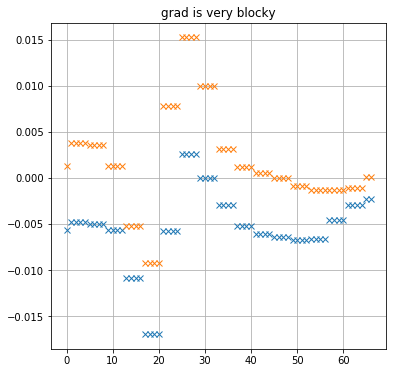

In [6]:
plt.figure(figsize=(6,6))
plt.plot(zp_t0_raw.grad.tolist(),'x') #needs the to list or it plots against index
plt.title('grad is very blocky')
plt.grid()
plt.show()

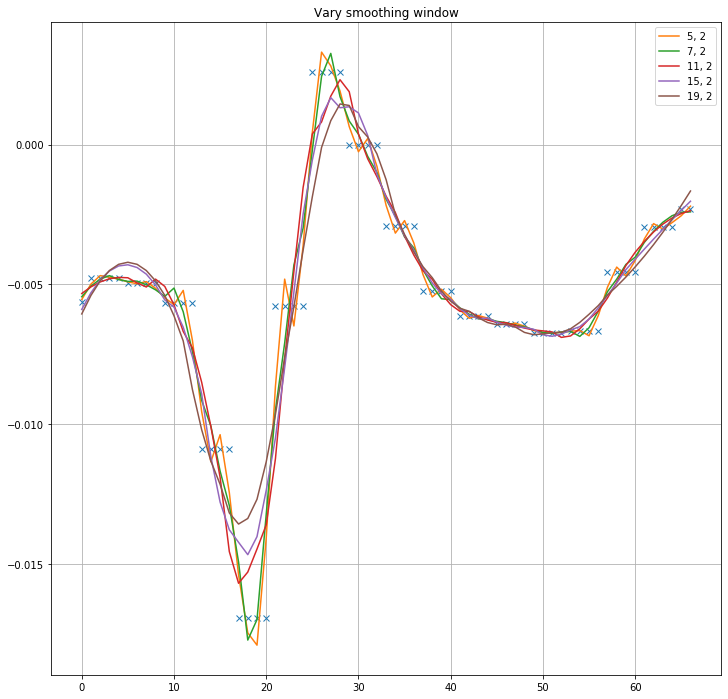

In [7]:
plt.figure(figsize=(12,12))
degree = 2
grads = np.array([ [grad[0],grad[1]] for grad in zp_t0_raw.grad.tolist() ])
plt.plot(grads[:,0],'x')
for window in [5,7,11,15,19]: 
    da = smooth_grad(daa,window,degree)
    da = calculate_zp(da)
    zp_t0 = da[da.timestamp.dt.date==min(da.timestamp.dt.date.unique())].copy()
    grads = np.array([ [grad[0],grad[1]] for grad in zp_t0.grad.tolist() ])
    plt.plot(grads[:,0],'-',label=f"{window}, {degree}") #needs the to list or it plots against index
    plt.legend()
    plt.grid()
plt.title('Vary smoothing window')
plt.show()

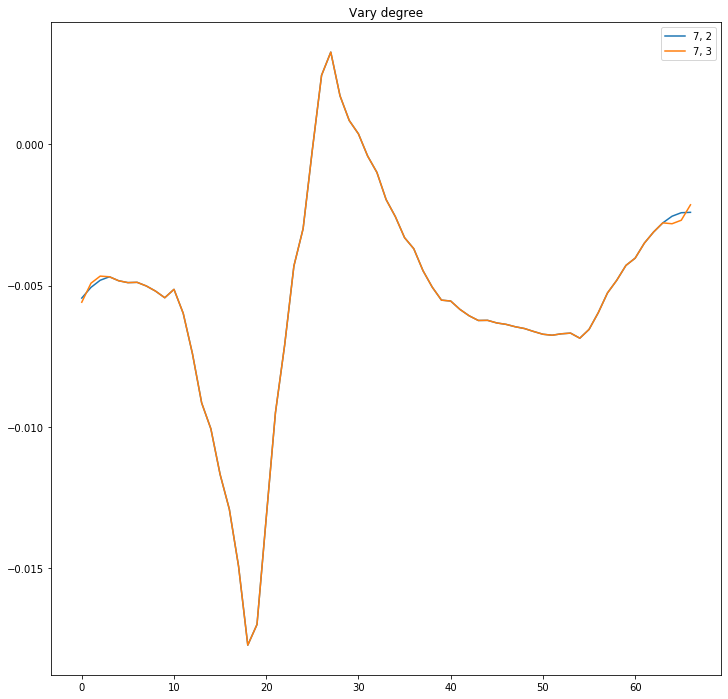

In [8]:
plt.figure(figsize=(12,12))
window = 7
for degree in [2,3]:
    da = smooth_grad(daa,window,degree)
    da = calculate_zp(da)
    zp_t0 = da[da.timestamp.dt.date==min(da.timestamp.dt.date.unique())].copy()
    grads = np.array([ [grad[0],grad[1]] for grad in zp_t0.grad.tolist() ])
    plt.plot(grads[:,0],'-',label=f"{window}, {degree}") #needs the to list or it plots against index
    plt.legend()
    plt.grid()
plt.title('Vary degree')
plt.show()

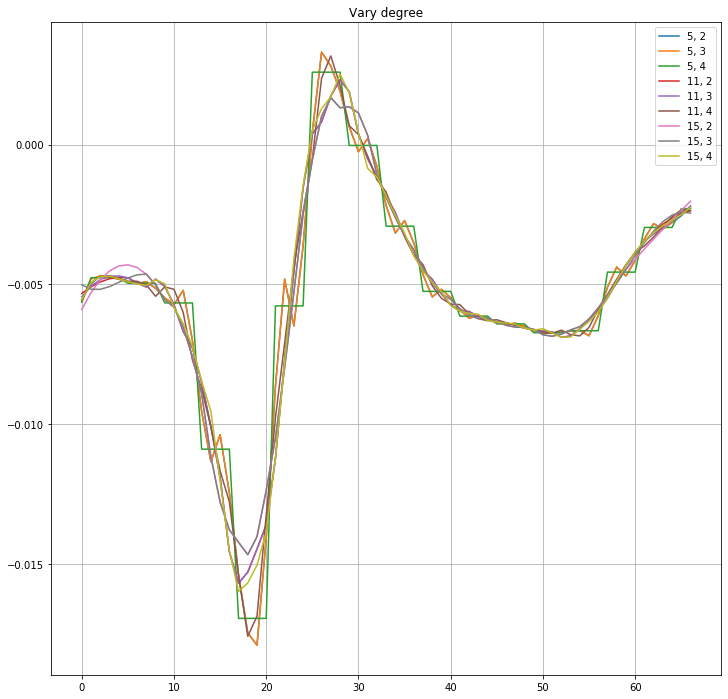

In [9]:
plt.figure(figsize=(12,12))
for window in [5,11,15]: 
    for degree in [2,3,4]:
        da = smooth_grad(daa,window,degree)
        da = calculate_zp(da)
        zp_t0 = da[da.timestamp.dt.date==min(da.timestamp.dt.date.unique())].copy()
        grads = np.array([ [grad[0],grad[1]] for grad in zp_t0.grad.tolist() ])
        plt.plot(grads[:,0],'-',label=f"{window}, {degree}") #needs the to list or it plots against index
        plt.legend()
        plt.grid()
plt.title('Vary degree')
plt.show()

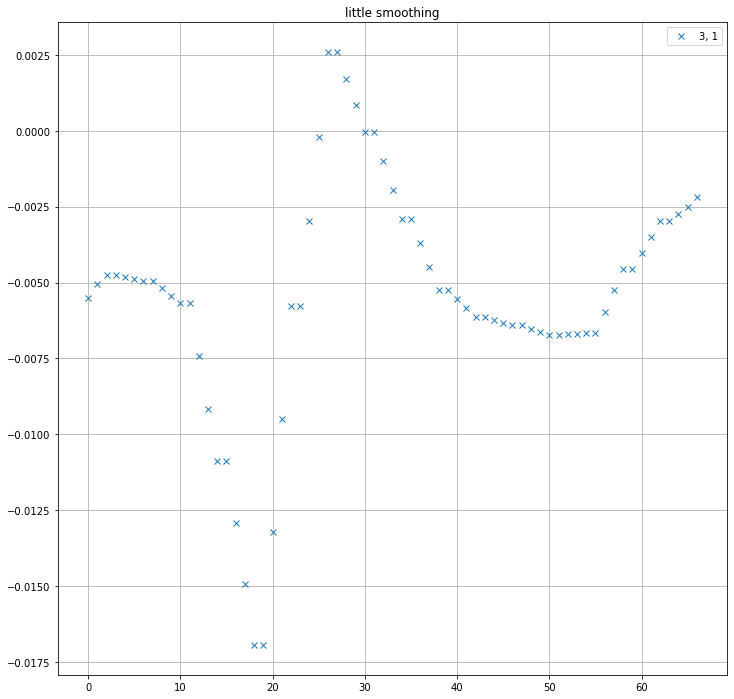

In [10]:
plt.figure(figsize=(12,12))
window = 3
degree = 1

da = smooth_grad(daa,window,degree)
da = calculate_zp(da)
zp_t0 = da[da.timestamp.dt.date==min(da.timestamp.dt.date.unique())].copy()
grads = np.array([ [grad[0],grad[1]] for grad in zp_t0.grad.tolist() ])
plt.plot(grads[:,0],'x',label=f"{window}, {degree}") #needs the to list or it plots against index
plt.legend()
plt.grid()
plt.title('little smoothing')
plt.show()

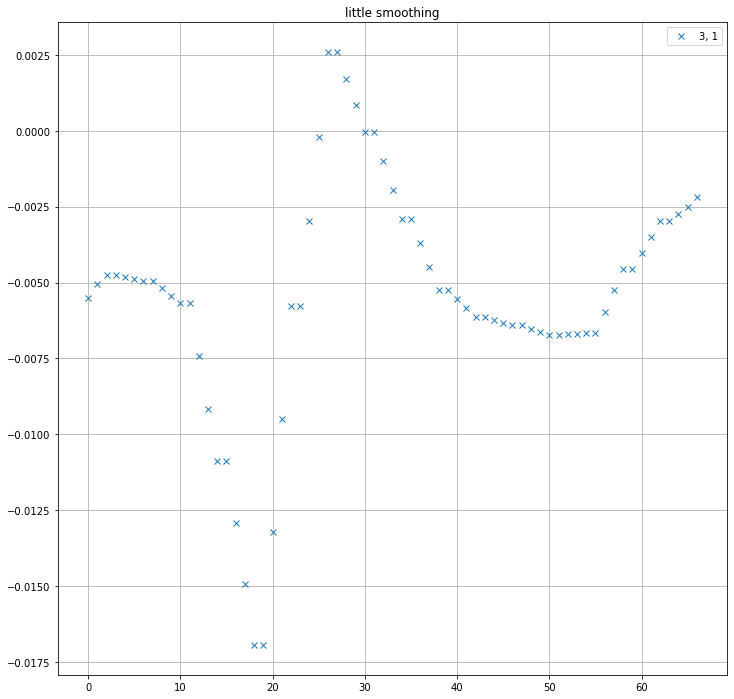

In [11]:
plt.figure(figsize=(12,12))
window = 3
degree = 1

da = smooth_grad(daa,window,degree)
da = calculate_zp(da)
zp_t0 = da[da.timestamp.dt.date==min(da.timestamp.dt.date.unique())].copy()
grads = np.array([ [grad[0],grad[1]] for grad in zp_t0.grad.tolist() ])
plt.plot(grads[:,0],'x',label=f"{window}, {degree}") #needs the to list or it plots against index
plt.legend()
plt.grid()
plt.title('little smoothing')
plt.show()

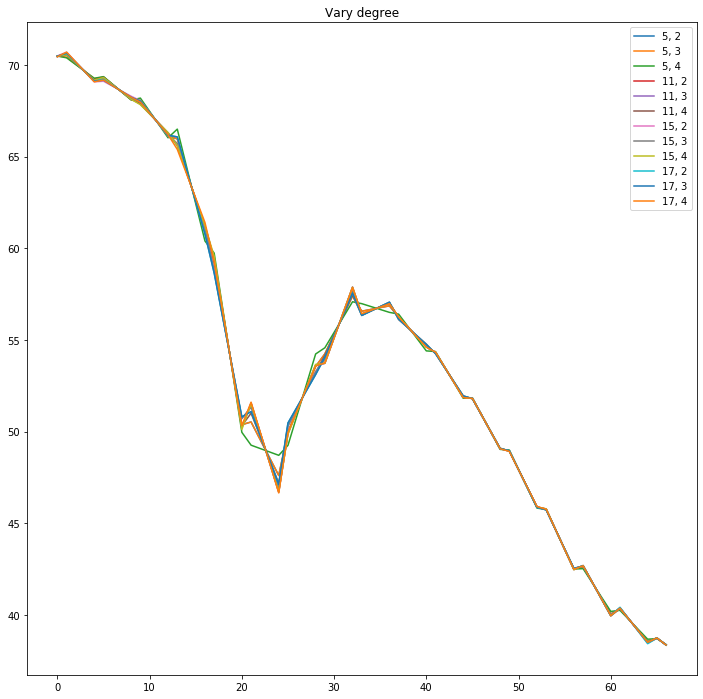

In [12]:
plt.figure(figsize=(12,12))
for window in [5,11,15,17]: 
    for degree in [2,3,4]:
        da = smooth_grad(daa,window,degree)
        da = calculate_zp(da)
        zp_t0 = da[da.timestamp.dt.date==min(da.timestamp.dt.date.unique())].copy()
        plt.plot(zp_t0.zp.tolist(),'-',label=f"{window}, {degree}") #needs the to list or it plots against index
        plt.legend()
        plt.grid()
plt.title('Vary degree')
plt.show()

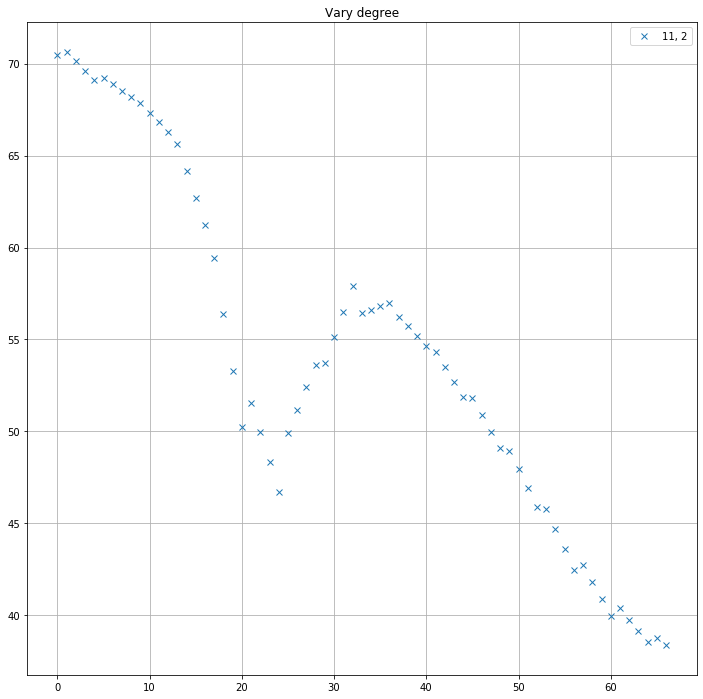

In [13]:
plt.figure(figsize=(12,12))
for window in [11]: 
    for degree in [2]:
        da = smooth_grad(daa,window,degree)
        da = calculate_zp(da)
        zp_t0 = da[da.timestamp.dt.date==min(da.timestamp.dt.date.unique())].copy()
        grads = np.array([ [grad[0],grad[1]] for grad in zp_t0.grad.tolist() ])
        plt.plot(zp_t0.zp.tolist(),'x',label=f"{window}, {degree}") #needs the to list or it plots against index
        plt.legend()
        plt.grid()
plt.title('Vary degree')
plt.show()

# Smoothing the grad isnt working. 
## Instead smooth the final slope

# First try for track = 'track0211'

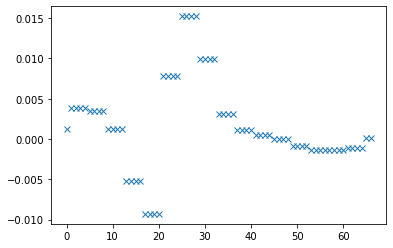

In [14]:
#then try doing it by smoothing the actual zp
da.keys()
track = 'track0211'

gd_chan = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/linedownchan.shp")

da = icesat1_load_alldzdt_pickle(track)

window = 7
degree = 3
dzdts = []
dates = []
zp_t0 = da[da.timestamp.dt.date==min(da.timestamp.dt.date.unique())].copy()
zp_t0['x_smooth'] = savgol_filter(zp_t0.x,window,degree)
zp_t0['zp_smooth'] = savgol_filter(zp_t0.zp,window,degree)
grads = np.array([[grad[0],grad[1]] for grad in zp_t0.grad.tolist()])
plt.plot(grads[:,1],'x')
plt.show()

In [15]:
passes = {}
dz_dts = []
dates = []
for pass_date in da.sort_values(['timestamp'],axis=0).timestamp.dt.date.unique():
  
    da_date = da[da.timestamp.dt.date==pass_date].copy() #dataframe restricted to the area, restricted to a cetrain date
    if da_date.shape[0] < len(zp_t0.x) - 5:            
        print(f'not enough data for {pass_date}, only {da_date.shape[0]} points')
        continue
    da_date['x_smooth'] = savgol_filter(da_date.x,window,degree)
    da_date['zp_smooth'] = savgol_filter(da_date.zp,window,degree)
    

    #interpolate so that we can
    f = interpolate.interp1d(da_date.x_smooth, da_date.zp_smooth,fill_value="extrapolate")
    dz_dts.append( ( f(zp_t0.x_smooth) - zp_t0.zp_smooth.tolist() ) )
    dates.append( pass_date )
    passes[str(pass_date)] = da_date
    del da_date
    

not enough data for 2006-11-14, only 56 points
not enough data for 2009-03-21, only 7 points


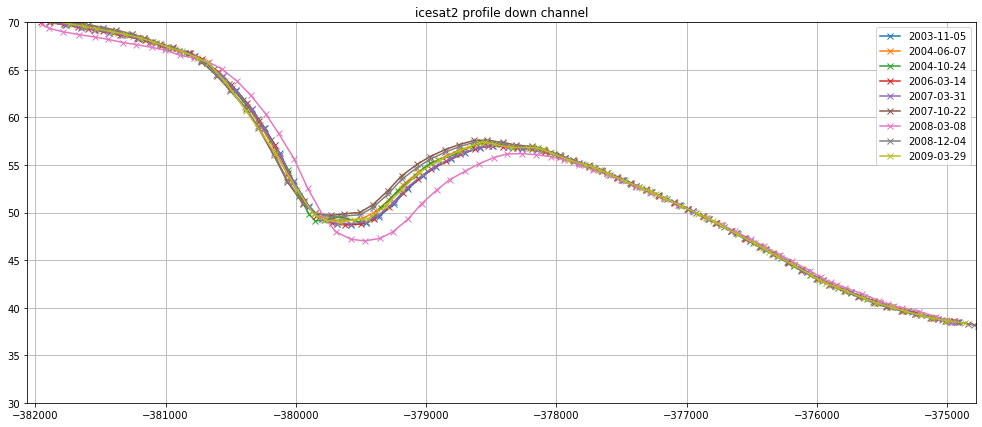

In [16]:
plt.figure(figsize=(17,7))
for pas in passes.values():
    plt.plot(pas.x_smooth,  pas.zp_smooth,'x-',label=pas.timestamp.dt.date.iloc[0])
plt.xlim([-382064.5722209641,-374781.1654740692])
plt.ylim([30, 70])
plt.title('icesat2 profile down channel')
plt.legend()
plt.grid()
    

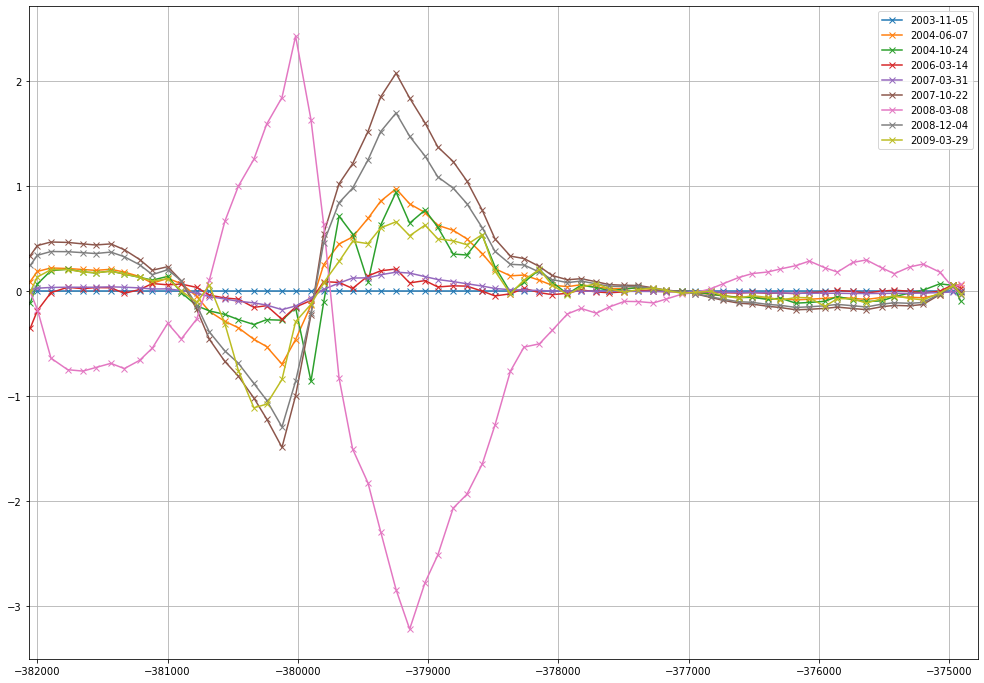

In [17]:
plt.figure(figsize=(17,12))
for date,dz_dt in zip(dates,dz_dts):
    # if date ==dt.date(2008, 3, 8):
    #     continue
    plt.plot(zp_t0.x_smooth.tolist(),dz_dt,'x-',label=date)
    plt.xlim([-382064.5722209641,-374781.1654740692])
    plt.legend()
plt.grid()
plt.show()

In [18]:
#then plot actual melt rate

dz_dts_rates = [] # change in elevation in m / y
dates = []
z_0 = zp_t0.zp_smooth.to_numpy() 
date_0 = zp_t0.timestamp.dt.date.iloc[0]
for pass_date in da.sort_values(['timestamp'],axis=0).timestamp.dt.date.unique()[1:]:
  
    da_date = da[da.timestamp.dt.date==pass_date].copy() #dataframe restricted to the area, restricted to a cetrain date
    if da_date.shape[0] < len(zp_t0.x) - 5:            
        print(f'not enough data for {pass_date}, only {da_date.shape[0]} points')
        continue
    da_date['x_smooth'] = savgol_filter(da_date.x,window,degree)
    da_date['zp_smooth'] = savgol_filter(da_date.zp,window,degree)
    

    #interpolate so that we can
    f = interpolate.interp1d(da_date.x_smooth, da_date.zp_smooth,fill_value="extrapolate")
    z_1 = f(zp_t0.x_smooth)
    date_1 = pass_date
    
    dz_dts_rates.append( (z_1 - z_0 ) / (date_1 - date_0).days /365.2422 )
    
    z_0 = z_1.copy()
    
    dates.append( pass_date )
    del da_date
    

not enough data for 2006-11-14, only 56 points
not enough data for 2009-03-21, only 7 points


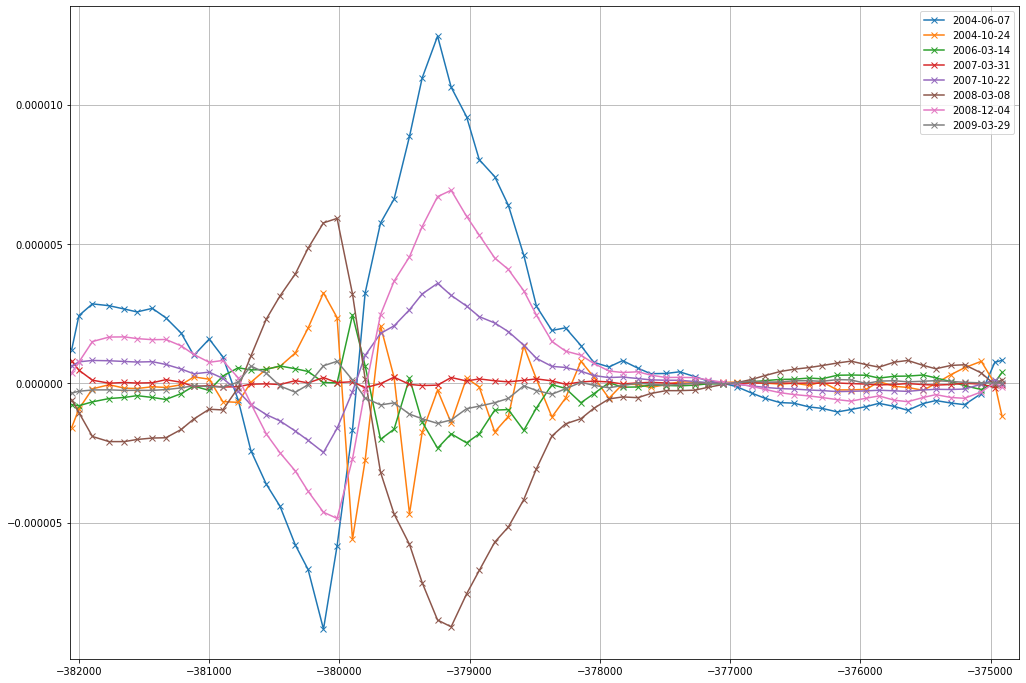

In [19]:
plt.figure(figsize=(17,12))
for date,dz_dt_rate in zip(dates,dz_dts_rates):
    plt.plot(zp_t0.x_smooth,dz_dt_rate,'x-',label=date)
    plt.xlim([-382064.5722209641,-374781.1654740692])
    plt.legend()
plt.grid()
plt.show()

# Ah shit. After all that i think that the tide correction or something isnt good enough, no consistancy in melt over time

In [20]:
maxs = [dz_dt_rate[np.argmax(np.abs(dz_dt_rate))] for dz_dt_rate in dz_dts_rates ] #find the biggest peak or trough

maxs_atchan = [dz_dt_rate[14] for dz_dt_rate in dz_dts_rates ] #find the biggest peak or trough

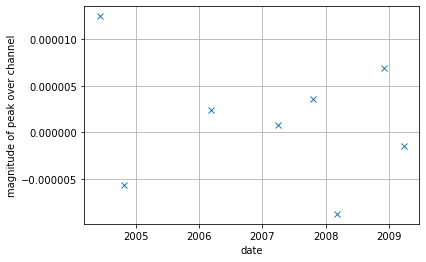

In [21]:
plt.plot(dates,maxs,'x')
plt.grid()
plt.xlabel('date')
plt.ylabel('magnitude of peak over channel')
plt.show()

In [22]:
#to find index at bottom of channel
# plt.plot(passes['2003-11-05'].zp.tolist()[10:30],'x')
# np.argmin(passes['2003-11-05'].zp.tolist()[10:30])

ValueError: x and y must have same first dimension, but have shapes (7,) and (8,)

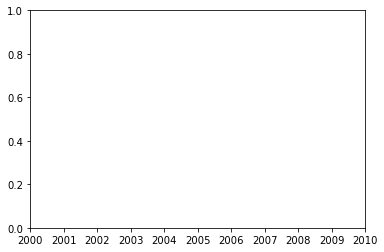

In [23]:
plt.plot(dates[1:],maxs_atchan,'x')
plt.grid()
plt.xlabel('date')
plt.ylabel('magnitude of peak over channel')
plt.show()

In [ ]:
# passes = {}
# plt.figure(figsize=(17,7))
# for pass_date in da.sort_values(['timestamp'],axis=0).timestamp.dt.date.unique():

#     da_date = da[da.timestamp.dt.date==pass_date].copy() #dataframe restricted to the area, restricted to a cetrain date
#     if da_date.shape[0] < len(zp_t0.x) - 5:            
#         print(f'not enough data for {pass_date}, only {da_date.shape[0]} points')
#         continue
#     da_date['x_smooth'] = savgol_filter(da_date.x,window,degree)
#     da_date['zp_smooth'] = savgol_filter(da_date.zp,window,degree)
#     passes[str(pass_date)] = da_date

#     #interpolate so that we can
#     f = interpolate.interp1d(da_date.x_smooth, da_date.zp_smooth,fill_value="extrapolate")
#     dzdts.append( f(zp_t0.x_smooth) - zp_t0.zp_smooth )
#     dates.append( pass_date )
    

#     plt.plot(da_date.x_smooth,  da_date.zp_smooth,'x-',label=pass_date)
#     plt.xlim([-382064.5722209641,-374781.1654740692])
#     plt.ylim([30, 70])
#     plt.title('icesat2 profile down channel')
#     plt.grid()
# plt.legend()
# plt.show()

In [ ]:
plt.figure(figsize=(17,12))
for p,date in zip(dz_dts,dates):
    # if date ==dt.date(2008, 3, 8):
    #     continue
    plt.plot(zp_t0.x_smooth,p,'x-',label=date)
    plt.xlim([-382064.5722209641,-374781.1654740692])
    plt.legend()
plt.grid()
plt.show()

# Next try for track = 'track0099'

In [ ]:
#then try doing it by smoothing the actual zp
da.keys()
track = 'track0099'

gd_chan = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/linedownchan.shp")

da = icesat1_load_alldzdt_pickle(track)

window = 7
degree = 3
dzdts = []
dates = []
zp_t0 = da[da.timestamp.dt.date==min(da.timestamp.dt.date.unique())].copy()
zp_t0['y_smooth'] = savgol_filter(zp_t0.y,window,degree)
zp_t0['zp_smooth'] = savgol_filter(zp_t0.zp,window,degree)
grads = np.array([[grad[0],grad[1]] for grad in zp_t0.grad.tolist()])
plt.plot(grads[:,1],'x')
plt.show()

In [ ]:
passes = {}
dz_dts = []
dates = []
for pass_date in da.sort_values(['timestamp'],axis=0).timestamp.dt.date.unique():
  
    da_date = da[da.timestamp.dt.date==pass_date].copy() #dataframe restricted to the area, restricted to a cetrain date
    if da_date.shape[0] < len(zp_t0.x) - 5:            
        print(f'not enough data for {pass_date}, only {da_date.shape[0]} points')
        continue
    da_date['y_smooth'] = savgol_filter(da_date.y,window,degree)
    da_date['zp_smooth'] = savgol_filter(da_date.zp,window,degree)
    

    #interpolate so that we can
    f = interpolate.interp1d(da_date.y_smooth, da_date.zp_smooth,fill_value="extrapolate")
    dz_dts.append( ( f(zp_t0.y_smooth) - zp_t0.zp_smooth.tolist() ) )
    dates.append( pass_date )
    passes[str(pass_date)] = da_date
    del da_date
    

In [ ]:
plt.figure(figsize=(17,7))
for pas in passes.values():
    plt.plot(pas.y_smooth,  pas.zp_smooth,'x-',label=pas.timestamp.dt.date.iloc[0])
plt.xlim([ -734075.0820404041,-722764.4514729496])
plt.ylim([20, 65])
plt.title('icesat2 profile down channel')
plt.legend()
plt.grid()
    

In [ ]:
plt.figure(figsize=(17,12))
for date,dzdt in zip(dates,dz_dts):
    # if date ==dt.date(2008, 3, 8):
    #     continue
    plt.plot(zp_t0.y_smooth,dzdt,'x-',label=date)
    plt.xlim([ -734075.0820404041,-722764.4514729496])
    plt.legend()
plt.grid()
plt.show()

In [ ]:
#then plot actual melt rate

passes = {}
dz_dts_rates = [] # change in elevation in m / y
dates = []
z_0 = zp_t0.zp_smooth.to_numpy() 
date_0 = zp_t0.timestamp.dt.date.iloc[0]
for pass_date in da.sort_values(['timestamp'],axis=0).timestamp.dt.date.unique()[1:]:
  
    da_date = da[da.timestamp.dt.date==pass_date].copy() #dataframe restricted to the area, restricted to a cetrain date
    if da_date.shape[0] < len(zp_t0.y) - 5:            
        print(f'not enough data for {pass_date}, only {da_date.shape[0]} points')
        continue
    da_date['y_smooth'] = savgol_filter(da_date.y,window,degree)
    da_date['zp_smooth'] = savgol_filter(da_date.zp,window,degree)
    

    #interpolate so that we can
    f = interpolate.interp1d(da_date.y_smooth, da_date.zp_smooth,fill_value="extrapolate")
    z_1 = f(zp_t0.y_smooth)
    date_1 = pass_date
    
    dz_dts_rates.append( (z_1 - z_0 ) / (date_1 - date_0).days /365.2422 )
    
    z_0 = z_1.copy()
    
    dates.append( pass_date )
    del da_date
    

In [ ]:
plt.figure(figsize=(17,12))
for date,dz_dt_rate in zip(dates,dz_dts_rates):
    plt.plot(zp_t0.y_smooth,dz_dt_rate,'x-',label=date)
    plt.xlim([ -734075.0820404041,-722764.4514729496])
    plt.legend()
plt.grid()
plt.show()

# Any consistancy over time

In [ ]:
maxs = [dz_dt_rate[np.argmax(np.abs(dz_dt_rate))] for dz_dt_rate in dz_dts_rates ] #find the biggest peak or trough

maxs_atchan = [dz_dt_rate[57] for dz_dt_rate in dz_dts_rates ] #find the biggest peak or trough

In [ ]:
plt.plot(dates,maxs,'x')
plt.grid()
plt.xlabel('date')
plt.ylabel('magnitude of peak over channel')
plt.show()

In [ ]:
plt.plot(dates,maxs_atchan,'x')
plt.grid()
plt.xlabel('date')
plt.ylabel('magnitude of peak over channel')
plt.show()

# Over the channel exactly

In [ ]:
#index of the channel is at
# np.argmin(passes['2003-10-29'].zp_smooth)

In [ ]:
maxs = [dz_dt_rate[57] for dz_dt_rate in dz_dts_rates ] #find the biggest peak or trough

In [ ]:
len(dates)

In [ ]:
plt.plot(dates,maxs,'x')
plt.grid()
plt.xlabel('date')
plt.ylabel('magnitude of peak over channel')
plt.show()

In [ ]:
# passes = {}
# plt.figure(figsize=(17,7))
# for pass_date in da.sort_values(['timestamp'],axis=0).timestamp.dt.date.unique():

#     da_date = da[da.timestamp.dt.date==pass_date].copy() #dataframe restricted to the area, restricted to a cetrain date
#     if da_date.shape[0] < len(zp_t0.x) - 5:            
#         print(f'not enough data for {pass_date}, only {da_date.shape[0]} points')
#         continue
#     da_date['x_smooth'] = savgol_filter(da_date.x,window,degree)
#     da_date['zp_smooth'] = savgol_filter(da_date.zp,window,degree)
#     passes[str(pass_date)] = da_date

#     #interpolate so that we can
#     f = interpolate.interp1d(da_date.x_smooth, da_date.zp_smooth,fill_value="extrapolate")
#     dzdts.append( f(zp_t0.x_smooth) - zp_t0.zp_smooth )
#     dates.append( pass_date )
    

#     plt.plot(da_date.x_smooth,  da_date.zp_smooth,'x-',label=pass_date)
#     plt.xlim([-382064.5722209641,-374781.1654740692])
#     plt.ylim([30, 70])
#     plt.title('icesat2 profile down channel')
#     plt.grid()
# plt.legend()
# plt.show()

# Now see how the rate changes for each year



In [ ]:
!git add .

In [ ]:
!git commit -m 'cant see much change in the rate (icesat1 passes)'